**<font size="6.5">Project 1: Bitcoin Price Prediction</font>**

# Introduction

The aim of the project is to predict bitcoin price (adjusted closing price) using historical data such as high, low, open, close, volume by applying different machine learning or time series techniques. Firstly, I got data from yahoo finance using relevant Python library. Then, I preprocessed the raw data including splitting training and test data as well as scaling the data between 0 and 1 for later model building process.

After preparing the data, I firstly tried LSTM method and applied <code>GridSearchCV</code> algorithm to pick up optimal hyperparameters for <code>activ_func</code> and <code>neurons</code>. Due to the limitation of computational power, I only picked those two parameters that I think is most important to optimize. Secondly, I tried KNN regression by taking the last day's data as feature and today's adjusted closing price as target. I also applied <code>GridSearchCV</code> algorithm to get the best number of neighbors. Thirdly, I used more traditional time series analysis method called SARIMA (Seasonal Autoregressive Integrated Moving Average). Instead of using <code>GridSearchCV</code>, the goodness of fit of SARIMA can be measured by AIC(Akaike Information Criterion). The smaller AIC, the better. I used <code>auto_arima</code> library which is able to calculate AIC and select the model with optimal parameter for me. After selecting the parameter, in order to simulate the prediction process, I would build a new SARIMA model every trading day since we are getting new information and a new model with updated information is needed. <code>pmdarima</code> library actually provides a very efficient way to update the model with a small piece of information everytime. According to the documentation, internally, the update or refresh step uses the existing parameters, taking a small amount of steps and allowing MLE to update your parameters a small amount. 

After building all three models, I would apply each of them on the same test data, compare them using mean absolute error, mean absolute percentage error and runtime for training and enquiry and finally pick the best model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import warnings
import time
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from pmdarima.arima import auto_arima
import pmdarima as pm

In [3]:
seed = 2296
np.random.seed(seed)

# Get Data from Yahoo

In [4]:
crypto_currency = 'BTC'
against_currency = 'USD'
start = dt.datetime(2018,1,1)
end = dt.datetime(2022,4,1)
data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end-dt.timedelta(days=1))

In [5]:
data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-01,14112.200195,13154.700195,14112.200195,13657.200195,10291200000,13657.200195
2018-01-02,15444.599609,13163.599609,13625.000000,14982.099609,16846600192,14982.099609
2018-01-03,15572.799805,14844.500000,14978.200195,15201.000000,16871900160,15201.000000
2018-01-04,15739.700195,14522.200195,15270.700195,15599.200195,21783199744,15599.200195
2018-01-05,17705.199219,15202.799805,15477.200195,17429.500000,23840899072,17429.500000
...,...,...,...,...,...,...
2022-03-28,48086.835938,46690.203125,46821.851562,47128.003906,36362175703,47128.003906
2022-03-29,48022.289062,47100.437500,47100.437500,47465.730469,31397059069,47465.730469
2022-03-30,47655.148438,46746.210938,47456.898438,47062.664062,29333883962,47062.664062


# Data Preprocessing

In [6]:
def train_test_split(df, test_size):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [7]:
def nomarlize_data(df):
    return (df - df.min()) / (data.max() - df.min())

In [8]:
data = nomarlize_data(data)
train_data, test_data = train_test_split(data, test_size=0.2)

In [9]:
test_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-05-27,0.566354,0.538949,0.561012,0.547181,0.115753,0.547181
2021-05-28,0.543112,0.499879,0.548420,0.504598,0.150201,0.504598
2021-05-29,0.518347,0.482707,0.504527,0.487786,0.121557,0.487786
2021-05-30,0.505620,0.479966,0.487785,0.504296,0.082525,0.504296
2021-05-31,0.521915,0.491379,0.504130,0.530018,0.103683,0.530018
...,...,...,...,...,...,...
2022-03-28,0.683996,0.688374,0.677705,0.682282,0.096075,0.682282
2022-03-29,0.683010,0.694866,0.682037,0.687532,0.081810,0.687532
2022-03-30,0.677406,0.689261,0.687580,0.681266,0.075882,0.681266


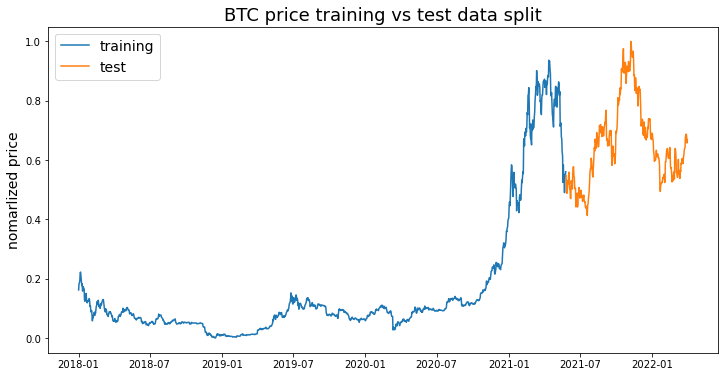

In [10]:
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.plot(train_data['Adj Close'], label='training')
ax.plot(test_data['Adj Close'], label='test')
ax.set_ylabel('nomarlized price', fontsize=14)
ax.set_title(f'{crypto_currency} price training vs test data split', fontsize=18)
ax.legend(loc='best', fontsize=14)

# Machine Learning Methods

## LSTM Model

In [11]:
class LSTM_Model:
    def __init__(self, window_len):
        self.model = None
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.y_pred = None
        self.param_grid = None
        self.window_len = window_len
        self.mae = None
        self.mape = None
        self.train_time = None
        self.enquiry_time = None
        
    def extract_window_data(self, df):
        window_data = []
        for idx in range(len(df) - self.window_len):
            tmp = df[idx: (idx + self.window_len)].copy()
            window_data.append(tmp.values)
        return np.array(window_data)
    
    def prepare_data(self, train_data, test_data):
        self.x_train = self.extract_window_data(train_data)
        self.x_test = self.extract_window_data(test_data)
        self.y_train = train_data['Adj Close'][self.window_len:].values
        self.y_test = test_data['Adj Close'][self.window_len:].values
    
    def build_lstm_model(self, input_data, neurons=100, activ_func='linear', dropout=0.2, loss='mae', optimizer='adam'):
        self.model = Sequential()
        self.model.add(LSTM(neurons, return_sequences=True, input_shape=(input_data.shape[1], input_data.shape[2])))
        self.model.add(Dropout(dropout))
        self.model.add(LSTM(neurons, return_sequences=True))
        self.model.add(Dropout(dropout))
        self.model.add(LSTM(neurons))
        self.model.add(Dropout(dropout))
        self.model.add(Dense(units=1))
        self.model.add(Activation(activ_func))
        self.model.compile(loss=loss, optimizer=optimizer)
        return self.model

In [12]:
lstm_obj = LSTM_Model(window_len=3)

In [13]:
lstm_obj.prepare_data(train_data, test_data)

### Adjust Hyperparameters

We have to use a wrapper for our <code>build_lstm_model</code> function so that we can apply <code>GridSearchCV</code> algorithm to choose optimal parameters.

In [14]:
regressor_wrapper = KerasRegressor(build_fn=lstm_obj.build_lstm_model, input_data=lstm_obj.x_train)

In [15]:
activ_func = ['relu', 'tanh', 'sigmoid', 'linear']
neurons = [20, 50, 100]
lstm_obj.param_grid = dict(activ_func=activ_func, neurons=neurons)
grid_result  = GridSearchCV(estimator=regressor_wrapper,
                            param_grid=lstm_obj.param_grid,
                            scoring='neg_mean_absolute_error')

In [16]:
grid_result.fit(lstm_obj.x_train, lstm_obj.y_train)

39/39 [==============================] - 8s 14ms/step - loss: 0.0620


GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x0000016DB11E5D90>,
             param_grid={'activ_func': ['relu', 'tanh', 'sigmoid', 'linear'],
                         'neurons': [20, 50, 100]},
             scoring='neg_mean_absolute_error')

In [17]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.029562 using {'activ_func': 'relu', 'neurons': 100}
-0.100470 (0.136254) with: {'activ_func': 'relu', 'neurons': 20}
-0.067269 (0.117796) with: {'activ_func': 'relu', 'neurons': 50}
-0.029562 (0.030490) with: {'activ_func': 'relu', 'neurons': 100}
-0.110098 (0.143190) with: {'activ_func': 'tanh', 'neurons': 20}
-0.077288 (0.135494) with: {'activ_func': 'tanh', 'neurons': 50}
-0.052968 (0.085081) with: {'activ_func': 'tanh', 'neurons': 100}
-0.342615 (0.044536) with: {'activ_func': 'sigmoid', 'neurons': 20}
-0.278366 (0.080584) with: {'activ_func': 'sigmoid', 'neurons': 50}
-0.127150 (0.184475) with: {'activ_func': 'sigmoid', 'neurons': 100}
-0.101745 (0.137027) with: {'activ_func': 'linear', 'neurons': 20}
-0.065754 (0.096753) with: {'activ_func': 'linear', 'neurons': 50}
-0.053757 (0.082805) with: {'activ_func': 'linear', 'neurons': 100}


### Train Model with Optimal Hyperparameters

In [18]:
start = time.time()
lstm_obj.build_lstm_model(lstm_obj.x_train, activ_func=grid_result.best_params_['activ_func'], neurons=grid_result.best_params_['neurons'])
lstm_obj.model.fit(lstm_obj.x_train, lstm_obj.y_train, epochs=20, batch_size=32)
end = time.time()
lstm_obj.train_time = end - start

Epoch 1/20
39/39 [==============================] - 10s 14ms/step - loss: 0.0549
Epoch 2/20
39/39 [==============================] - 1s 15ms/step - loss: 0.0169
Epoch 3/20
39/39 [==============================] - 1s 15ms/step - loss: 0.0152
Epoch 4/20
39/39 [==============================] - 1s 17ms/step - loss: 0.0166
Epoch 5/20
39/39 [==============================] - 1s 18ms/step - loss: 0.0157
Epoch 6/20
39/39 [==============================] - 1s 17ms/step - loss: 0.0155
Epoch 7/20
39/39 [==============================] - 1s 22ms/step - loss: 0.0147
Epoch 8/20
39/39 [==============================] - 1s 22ms/step - loss: 0.0152
Epoch 9/20
39/39 [==============================] - 1s 17ms/step - loss: 0.0141
Epoch 10/20
39/39 [==============================] - 1s 16ms/step - loss: 0.0145
Epoch 11/20
39/39 [==============================] - 1s 18ms/step - loss: 0.0133
Epoch 12/20
39/39 [==============================] - 1s 17ms/step - loss: 0.0152
Epoch 13/20
39/39 [=================

### Prediction and Evaluation

In [19]:
start = time.time()
lstm_obj.y_pred = lstm_obj.model.predict(lstm_obj.x_test)
end = time.time()
lstm_obj.enquiry_time = end - start

In [20]:
lstm_obj.mae = mean_absolute_error(lstm_obj.y_pred, lstm_obj.y_test)
lstm_obj.mae

0.0334053934210211

In [21]:
lstm_obj.mape = mean_absolute_percentage_error(lstm_obj.y_pred, lstm_obj.y_test)
lstm_obj.mae

0.0334053934210211

In [22]:
np.std(lstm_obj.y_test)

0.13657116544109996

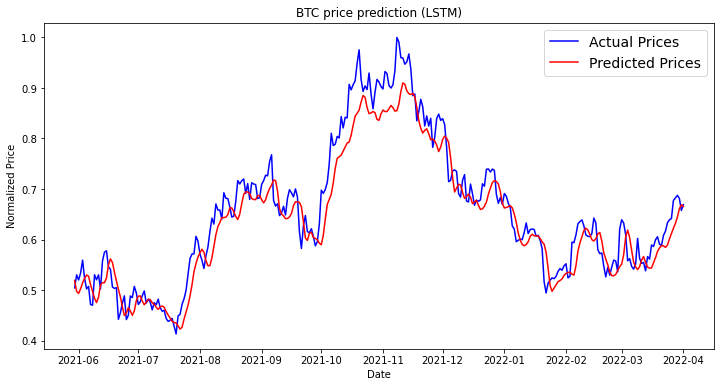

In [23]:
plt.figure(figsize=(12,6))
plt.plot(test_data[lstm_obj.window_len:].index, lstm_obj.y_test, color='blue', label='Actual Prices')
plt.plot(test_data[lstm_obj.window_len:].index, lstm_obj.y_pred, color='red', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction (LSTM)')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend(fontsize=14)
plt.show()

## KNN

In [24]:
class KNN_Model:
    def __init__(self):
        self.model = None
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.y_pred = None
        self.param_grid = None
        self.mae = None
        self.mape = None
        self.train_time = None
        self.enquiry_time = None
    
    def build_model(self, n_neighbors=5):
        self.model = neighbors.KNeighborsRegressor(n_neighbors=n_neighbors)
    
    def prepare_data(self, train_data, test_data):
        self.x_train = train_data.shift(1).dropna()
        self.y_train = train_data['Adj Close'].iloc[1:]
        self.x_test = test_data.shift(1).dropna()
        self.y_test = test_data['Adj Close'].iloc[1:]

In [25]:
knn_obj = KNN_Model()
knn_obj.prepare_data(train_data, test_data)
knn_obj.build_model()

### Adjust Hyperparameters

In [26]:
knn_obj.param_grid = {'n_neighbors':[2, 5, 10, 15, 20]}
grid_result = GridSearchCV(knn_obj.model, knn_obj.param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_result.fit(knn_obj.x_train, knn_obj.y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [2, 5, 10, 15, 20]},
             scoring='neg_mean_absolute_error')

In [27]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.069868 using {'n_neighbors': 5}
-0.070811 (0.120315) with: {'n_neighbors': 2}
-0.069868 (0.119658) with: {'n_neighbors': 5}
-0.071725 (0.123713) with: {'n_neighbors': 10}
-0.073192 (0.126498) with: {'n_neighbors': 15}
-0.075251 (0.130492) with: {'n_neighbors': 20}


### Train Model with Optimal Hyperparameters

In [28]:
start = time.time()
knn_obj.build_model(n_neighbors=grid_result.best_params_['n_neighbors'])
knn_obj.model.fit(knn_obj.x_train, knn_obj.y_train)
end = time.time()
knn_obj.train_time = end - start

### Prediction and Evaluation

In [29]:
start = time.time()
knn_obj.y_pred = knn_obj.model.predict(knn_obj.x_test)
end = time.time()
knn_obj.enquiry_time = end - start

In [30]:
knn_obj.mae = mean_absolute_error(knn_obj.y_pred, knn_obj.y_test)
knn_obj.mae

0.028632514705153232

In [31]:
knn_obj.mape = mean_absolute_percentage_error(knn_obj.y_pred, knn_obj.y_test)
knn_obj.mape

0.04385786714131579

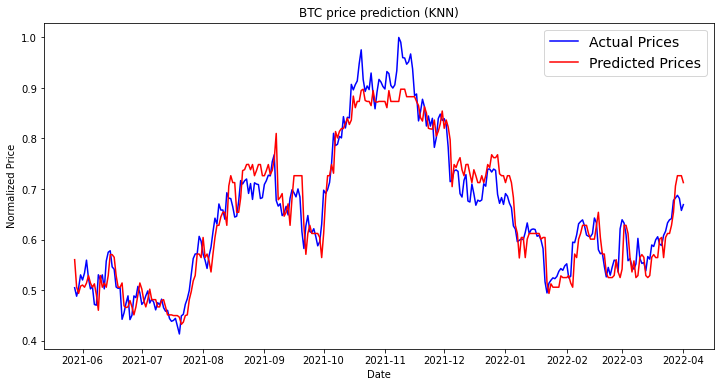

In [32]:
plt.figure(figsize=(12,6))
plt.plot(knn_obj.x_test.index, knn_obj.y_test, color='blue', label='Actual Prices')
plt.plot(knn_obj.x_test.index, knn_obj.y_pred, color='red', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction (KNN)')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend(fontsize=14)
plt.show()

## Auto ARIMA (SARIMA)

In [33]:
class SARIMA_Model:
    def __init__(self):
        self.model = None
        # self.length = length_of_test_data
        self.train_data = train_data['Adj Close'].values
        self.test_data = test_data['Adj Close'].values
        self.y_pred = []
        self.mae = None
        self.mape = None
        self.train_time = 0
        self.enquiry_time = 0

    def build_model(self):
        self.model =  auto_arima(self.train_data,start_p=0, d=1, start_q=0, 
                                 max_p=3, max_d=3, max_q=3, start_P=0, 
                                 D=1, start_Q=0, max_P=3, max_D=3,
                                 max_Q=3, m=12, seasonal=True, 
                                 error_action='ignore',trace =True, suppress_warnings=True,
                                 stepwise=True, random_state=20,n_fits=50)

    def train_and_predict(self, p, d, q ,P, D, Q, s):
        start = time.time()
        self.model = pm.ARIMA(order=(p,d,q), seasonal_order=(P, D, Q, s))
        self.model.fit(self.train_data, suppress_warnings=True, error_action='ignore')
        end = time.time()
        self.train_time += end - start
        for i in range(len(self.test_data)):
            start = time.time()
            yhat = self.model.predict(n_periods=1)[0]
            end = time.time()
            self.enquiry_time += end - start
            self.y_pred.append(yhat)
            true_test_value = self.test_data[i]

            start = time.time()
            self.model.update(true_test_value, suppress_warnings=True, error_action='ignore')
            end = time.time()
            self.train_time += end - start

### Adjust Hyperparameters

In [34]:
sarima_obj = SARIMA_Model()
sarima_obj.build_model()
sarima_obj.model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-6288.470, Time=0.45 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-6750.846, Time=1.48 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.47 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-6299.693, Time=0.20 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-6860.464, Time=1.76 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-6969.377, Time=6.86 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=16.25 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=12.98 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=-6969.166, Time=1.85 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=-6975.409, Time=8.01 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-6866.383, Time=5.34 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=-6897.574, Time=15.34 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=13.80 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=-6977.290, Time=13.46 sec
 ARIMA(3,1,0)(2,1,0)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1242
Model:             SARIMAX(3, 1, 0)x(3, 1, 0, 12)   Log Likelihood                3495.645
Date:                            Sun, 10 Apr 2022   AIC                          -6977.290
Time:                                    21:25:22   BIC                          -6941.492
Sample:                                         0   HQIC                         -6963.821
                                           - 1242                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0439      0.014     -3.161      0.002      -0.071      -0.017
ar.L2          0.0837      0.014      6.060      0.000       0.057       0.111
ar.L3          0.0568      0.016      3.560      0.000       0.026       0.088
ar.S.L12      -0.8600      0.011    -78.287      0.000      -0.881      -0.838
ar.S.L24      -0.5356      0.014    -39.413      0.000      -0.562      -0.509
ar.S.L36      -0.3559      0.015    -24.464      0.000      -0.384      -0.327
sigma2         0.0002   2.51e-06     78.262      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             19090.38
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              13.55   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Train Model and Predict

As we can see from output above, the best model is **SARIMAX(3, 1, 0)x(3, 1, 0, 12)**

In [35]:
sarima_obj.train_and_predict(3, 1, 0, 3, 1, 0, 12)

### Evaluation

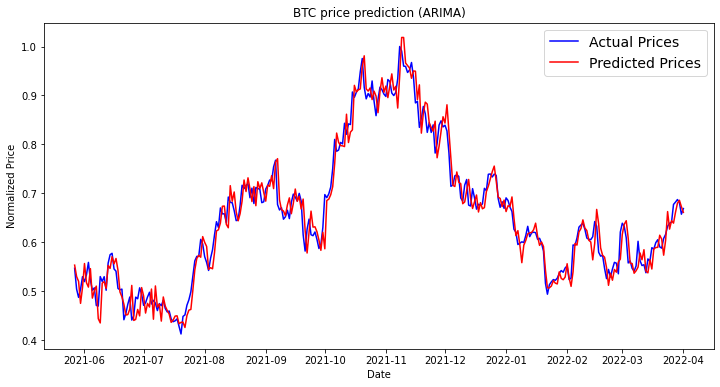

In [36]:
plt.figure(figsize=(12,6))
plt.plot(test_data.index, sarima_obj.test_data, color='blue', label='Actual Prices')
plt.plot(test_data.index, sarima_obj.y_pred, color='red', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend(fontsize=14)
plt.show()

In [37]:
sarima_obj.mae = mean_absolute_error(sarima_obj.y_pred, sarima_obj.test_data)
sarima_obj.mae

0.02164328821572362

In [38]:
sarima_obj.mape = mean_absolute_percentage_error(sarima_obj.y_pred, sarima_obj.test_data)
sarima_obj.mape

0.03401831993908218

# Comments and Conclusion

In [39]:
res_df = pd.DataFrame({'ML Methods':['LSTM', 'KNN', 'SARIMA'],
        'MAE':[0, 0, 0], 'MAPE': [0, 0, 0], 'Training Time (Seconds)':[0, 0, 0], 'Enquiry Time (Seconds)':[0, 0, 0]})
res_df.index = res_df['ML Methods']
res_df = res_df.drop(columns=['ML Methods'])

res_df.loc['LSTM', 'MAE'] = lstm_obj.mae
res_df.loc['LSTM', 'MAPE'] = lstm_obj.mape
res_df.loc['LSTM', 'Training Time (Seconds)'] = lstm_obj.train_time
res_df.loc['LSTM', 'Enquiry Time (Seconds)'] = lstm_obj.enquiry_time

res_df.loc['KNN', 'MAE'] = knn_obj.mae
res_df.loc['KNN', 'MAPE'] = knn_obj.mape
res_df.loc['KNN', 'Training Time (Seconds)'] = knn_obj.train_time
res_df.loc['KNN', 'Enquiry Time (Seconds)'] = knn_obj.enquiry_time


res_df.loc['SARIMA', 'MAE'] = sarima_obj.mae
res_df.loc['SARIMA', 'MAPE'] = sarima_obj.mape
res_df.loc['SARIMA', 'Training Time (Seconds)'] = sarima_obj.train_time
res_df.loc['SARIMA', 'Enquiry Time (Seconds)'] = sarima_obj.enquiry_time

In [40]:
res_df

,MAE,MAPE,Training Time (Seconds),Enquiry Time (Seconds)
ML Methods,,,,
LSTM,0.033405,0.052274,24.394035,1.96325
KNN,0.028633,0.043858,0.009997,0.00799
SARIMA,0.021643,0.034018,2578.818116,6.18678


In [41]:
np.std(test_data['Adj Close'])

0.13663107973481692

All 3 models perform very well considering that their MAE are between 2% and 3% while the standard deviation of the adjusted closing price during test period is over 13%. Surprisingly, the traditional statistical time series method SARIMA outperforms in terms of MAE and MAPE among these models. 

However, SARIMA prediction process takes me over 40 minutes to finish since for every iteration, I need to train a new SARIMA model with updated information although I have already used the efficient update function in <code>pmdarima</code> library as mentioned in Introduction section. The runtime is acceptable if we do medium frequency trading (e.g. rebalance several times during the day). But for high frequency trading, the runtime of training new model every time when new information comes in is not acceptable and if we do not update the model every time, the SARIMA performance would become worse. KNN actually runs fastest among these models while LSTM needs some time to train model (24 seconds) while it is relatively fast to enquire (~2 seconds).

Moreover, there are many areas in this project that we can improve in the future study. For example, as mentioned before, many parameters in LSTM are not optimized such as window length, dropout rate and number of layers. We may also add other processed features such as SMA, Bollinger Band and etc. Furthermore, we can convert the prediction into trading strategies. For example, if the model predicts the price will go up in the future, we buy the stock and vice versa.